# Tests source grid offset marginilisation

The pixelation of the lens mapping, and more particularly the (arbitrary) alignement of the coordinates of source plane, ca introduce a bias in the source reconstruction. To mitigate this, the simpler way is to sampled two additional parameters as we sample lens models, that are_x_/_y_ offsets of the source plane coordinates, prior to ray-traycing.

An other possibility is to quantify this bias _a priori_ given the settings and condiguration, in an analytical or semi-analytical way. This is the purpose of this notebook.

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import tqdm

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LightModel.Profiles.interpolation import Interpol

from slitronomy.Lensing.lensing_operator import LensingOperator, LensingOperatorInterpol
from slitronomy.Util.plot_util import nice_colorbar
from slitronomy.Util import util

%matplotlib inline

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

In [3]:
subgrid_res_source = 1

num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2) -->  if 1, means you we work in pixel units

In [4]:
# data specification (coordinates, etc.)
#kwargs_data = sim_util.data_configure_simple(num_pix, delta_pix, exp_time, background_rms, inverse=False)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    #'background_rms': background_rms,
    #'exposure_time': np.ones((num_pix, num_pix)) * exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

# PSF specification
kwargs_psf = {'psf_type': 'NONE'}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['SPEMD']
kwargs_spemd = {'theta_E': 1.6, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': -0.1, 'e2': 0.2}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
source_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic_ellipse_source = {'amp': 2000, 'R_sersic': 0.6, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1,
                                'center_x': 0.3, 'center_y': 0.3}
kwargs_source = [kwargs_sersic_ellipse_source]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = []
kwargs_lens_light = [{}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

In [5]:
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}

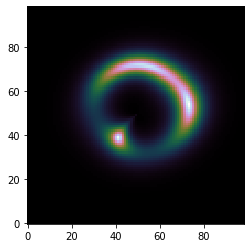

In [6]:
# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, kwargs_numerics=kwargs_numerics)

image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)
kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

plt.imshow(image_sim, origin='lower', cmap='cubehelix')
plt.show()

## Build the mapping between image and source plane

In [7]:
# define test images
test_image_ones = np.ones_like(image_sim)
test_source_ones = np.ones_like((num_pix*subgrid_res_source, num_pix*subgrid_res_source))

test_image_pixel = np.zeros_like(image_sim)
test_image_pixel[60, 70] = 1

test_source_pixel = np.zeros((num_pix*subgrid_res_source, num_pix*subgrid_res_source))
test_source_pixel[55, 55] = 1

# declare lensing operator
lensing_op_class = LensingOperatorInterpol(data_class, lens_model_class, subgrid_res_source=subgrid_res_source)

## Define test pixels for error quantification

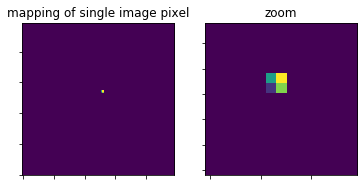

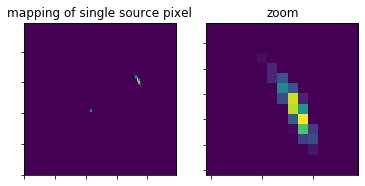

In [57]:
# reference mapping, when no offset
lensing_op_class.update_mapping(kwargs_lens, kwargs_special=None)

test_source_pixel_ref = lensing_op_class.image2source_2d(test_image_pixel)
test_image_pixel_ref = lensing_op_class.source2image_2d(test_source_pixel)

# ref source grid coordinates
x_grid_source_ref, y_grid_source_ref = lensing_op_class.sourcePlane.grid(two_dim=False)

plt.figure()
ax = plt.subplot(1, 2, 1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("mapping of single image pixel")
plt.imshow(test_source_pixel_ref, origin='lower', cmap='viridis')
ax = plt.subplot(1, 2, 2)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("zoom")
plt.imshow(test_source_pixel_ref[45:60, 45:60], origin='lower', cmap='viridis')

plt.figure()
ax = plt.subplot(1, 2, 1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("mapping of single source pixel")
plt.imshow(test_image_pixel_ref, origin='lower', cmap='viridis')
ax = plt.subplot(1, 2, 2)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("zoom")
plt.imshow(test_image_pixel_ref[55:70,65:80], origin='lower', cmap='viridis')
plt.show()

## Errors in source plane for different offsets
Compare the true mapping without grid offset and the mapping with an offset followed by an interpolation of the resulting image to correct the misalignment between the images (due to the grid offset).

100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


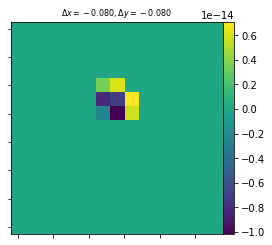

In [26]:
n_points = 1
offset_x_range = np.linspace(-delta_pix, delta_pix, n_points)
offset_y_range = np.linspace(-delta_pix, delta_pix, n_points)

c = 1
plt.figure(figsize=(4*n_points, 4*n_points))
for offset_x in tqdm.tqdm(offset_x_range):
    for offset_y in offset_y_range:
        # use kwargs_special to introduce offsets of source plane grid
        kwargs_special = {
            'delta_x_source_grid': offset_x,
            'delta_y_source_grid': offset_y,
        }

        # build lensing operator
        #start_map = time.time()
        lensing_op_class.update_mapping(kwargs_lens, kwargs_special=kwargs_special)
        #print("time to compute mapping : {:.3e} s".format(time.time()-start_map))

        # mapping of test images
        source = lensing_op_class.image2source_2d(test_image_pixel)
        
        # align back with coordinates of reference image
        if offset_x != 0 or offset_y != 0:
            source = Interpol().function(x_grid_source_ref, y_grid_source_ref,
                                         image=source, scale=delta_pix,
                                         center_x=offset_x, center_y=offset_y)
            source = lenstro_util.array2image(source)
        
        ax = plt.subplot(n_points, n_points, c)
        plt.title(r"$\Delta x={:.3f}, \Delta y={:.3f}$".format(offset_x, offset_y), fontsize=8)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        err = source - test_source_pixel_ref
        err /= test_source_pixel_ref.max()
        im = plt.imshow(err[45:60, 45:60], origin='lower', cmap='viridis')
        nice_colorbar(im, pad=0)
        c += 1
plt.show()

## Errors in image plane for different offsets
Compare the true delensing operation without source grid offset and the delensing with an an interpolation of the source image followed by the delensing operation.

100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


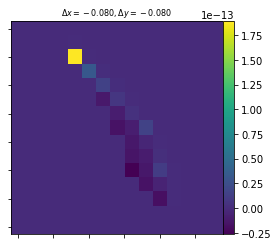

In [27]:
n_points = 1
offset_x_range = np.linspace(-delta_pix, delta_pix, n_points)
offset_y_range = np.linspace(-delta_pix, delta_pix, n_points)

c = 1
plt.figure(figsize=(4*n_points, 4*n_points))
for offset_x in tqdm.tqdm(offset_x_range):
    for offset_y in offset_y_range:
        # use kwargs_special to introduce offsets of source plane grid
        kwargs_special = {
            'delta_x_source_grid': offset_x,
            'delta_y_source_grid': offset_y,
        }

        # build lensing operator
        #start_map = time.time()
        lensing_op_class.update_mapping(kwargs_lens, kwargs_special=kwargs_special)
        #print("time to compute mapping : {:.3e} s".format(time.time()-start_map))
        
        if offset_x != 0 or offset_y != 0:
            #start_interp = time.time()
            test_source_pixel_i = Interpol().function(x_grid_source_ref, y_grid_source_ref,
                                         image=test_source_pixel, scale=delta_pix,
                                         center_x=-offset_x, center_y=-offset_y)
            test_source_pixel_i = lenstro_util.array2image(test_source_pixel_i)
            #print("time to interpolate : {:.3e} s".format(time.time()-start_interp))
        else:
            test_source_pixel_i = test_source_pixel

        # mapping of test images
        image = lensing_op_class.source2image_2d(test_source_pixel_i)

        ax = plt.subplot(n_points, n_points, c)
        plt.title(r"$\Delta x={:.3f}, \Delta y={:.3f}$".format(offset_x, offset_y), fontsize=8)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        err = image - test_image_pixel_ref
        err[test_image_pixel_ref != 0] /= test_image_pixel_ref[test_image_pixel_ref != 0]
        im = plt.imshow(err[55:70,65:80], origin='lower', cmap='viridis')
        nice_colorbar(im, pad=0)
        c += 1
plt.show()

## Integrate over offsets to get the net effect at a given location

In [11]:
# TODO : iterate on the position of the test image pixel + iterate on the pixel intensity

n_points = 5
offset_x_mesh, offset_y_mesh = np.meshgrid(np.linspace(-delta_pix, delta_pix, n_points),
                                           np.linspace(-delta_pix, delta_pix, n_points))

ref_image = test_image_pixel

lensing_op_class.update_mapping(kwargs_lens, kwargs_special=None)
ref_mapping = lensing_op_class.image2source_2d(ref_image)
ref_pixels = np.where(ref_mapping != 0)

mse_list = []  # mean square error
for i in tqdm.tqdm(range(n_points)):
    for j in range(n_points):
        offset_x, offset_y = offset_x_mesh[i, j], offset_y_mesh[i, j]
        #print(offset_x, offset_y)
        # use kwargs_special to introduce offsets of source plane grid
        kwargs_special = {
            'delta_x_source_grid': offset_x,
            'delta_y_source_grid': offset_y,
        }

        # build lensing operator
        lensing_op_class.update_mapping(kwargs_lens, kwargs_special=kwargs_special)

        # mapping of test images
        mapping = lensing_op_class.image2source_2d(ref_image)
        
        # align back with coordinates of reference image
        if offset_x != 0 or offset_y != 0:
            mapping = Interpol().function(x_grid_source_ref, y_grid_source_ref,
                                         image=mapping, scale=delta_pix,
                                         center_x=offset_x, center_y=offset_y)
            mapping = lenstro_util.array2image(mapping)
        
        mse = np.linalg.norm((mapping[ref_pixels] - ref_mapping[ref_pixels]).flatten(), 2)
        mse_list.append(mse)

100%|██████████| 5/5 [00:41<00:00,  8.30s/it]


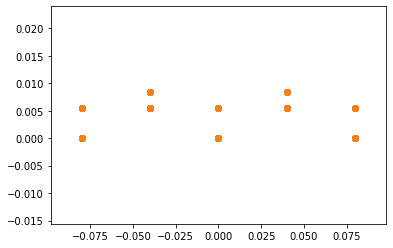

In [12]:
offset_r_mesh = np.sqrt(offset_x_mesh**2+offset_y_mesh**2).flatten()
plt.scatter(offset_x_mesh, mse_list)
plt.scatter(offset_y_mesh.flatten(), mse_list)
plt.show()

## Taking into account errors due to projection on a grid through the "regridding error"

Based on Suyu+2009 (https://ui.adsabs.harvard.edu/abs/2009ApJ...691..277S/abstract), where the authors define the following noise level, **per image plane pixel**, that has to be added to the noise map :
$$
(\sigma^2_{\rm regridding})_i = \frac1{12}\mu_i\frac{\Delta\beta^2}{\Delta\theta^2}\sum_{j\ \in\ {\rm adjacent\ to\ } i}^{N_{\rm adj}} \frac{(d_j - d_i)^2}{N_{\rm adj}}
$$

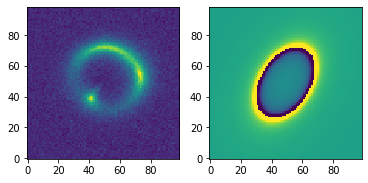

In [42]:
background_rms = 2
image_sim_noisy = image_sim + background_rms*np.random.randn(*image_sim.shape)
noise_map_gaussian = background_rms * np.ones_like(image_sim)

data_x_grid, data_y_grid = data_class.coordinate_grid(num_pix, num_pix)
mag_map = lens_model_class.magnification(lenstro_util.image2array(data_x_grid), lenstro_util.image2array(data_y_grid), kwargs_lens)
mag_map = lenstro_util.array2image(mag_map)

plt.subplot(1, 2, 1)
plt.imshow(image_sim_noisy, origin='lower')
plt.subplot(1, 2, 2)
plt.imshow(mag_map, origin='lower', vmin=-10, vmax=10)

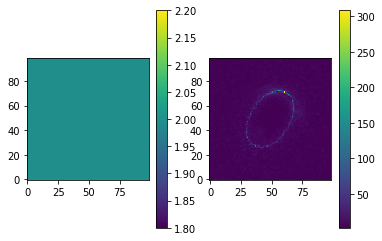

In [55]:
delta_pix_source = 0.08
regrid_noise2 = regridding_error_map_squared(image_sim_noisy, mag_map, delta_pix, delta_pix_source)
noise_map_eff = np.sqrt(regrid_noise2 + noise_map_gaussian**2)

plt.subplot(1, 2, 1)
plt.imshow(noise_map_gaussian, origin='lower')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(noise_map_eff, origin='lower')
plt.colorbar()